# Mini Project 2

In [1]:
import sys
from datetime import datetime
from datetime import timedelta
import scipy
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

from pandas import ExcelFile
import matplotlib.pyplot as plt

#suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Cause plots to be displayed in the notebook:
%matplotlib inline
#print('Available plot styles: ' + str(plt.style.available))
plt.style.use('seaborn-whitegrid')

print('Python: \t', sys.version)
print('Scipy:  \t', scipy.__version__)
print('Numpy:  \t', np.__version__)
print('Pandas: \t', pd.__version__)
print('MatPlotLib: \t', matplotlib.__version__)
print('Author: \t Lawrance Koh (@LK)')
print('Team:   \t Jav & LK AS Group 3')
print('='*100, "\n")

def parseDate(aDate):
    parsed_date = str(aDate)
    return(datetime.strptime(parsed_date[0:4] + "/" + parsed_date[4:6] + "/" + parsed_date[6:8], "%Y/%m/%d"))


Python: 	 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Scipy:  	 1.5.2
Numpy:  	 1.19.2
Pandas: 	 1.1.3
MatPlotLib: 	 3.3.2
Author: 	 Lawrance Koh (@LK)
Team:   	 Jav & LK AS Group 3



In [2]:
#Read & Inspect data
data = pd.read_csv("Trx data.csv", index_col=["CardID"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69215 entries, C0100000199 to C0106596676
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    69215 non-null  int64  
 1   Amount  69215 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.6+ MB


In [3]:
print('{:,} transactions'.format(data.shape[0]))
print('Transaction Timeframe: {} to {}'.format(parseDate(data['Date'].min()), parseDate(data['Date'].max())))

69,215 transactions
Transaction Timeframe: 2001-01-01 00:00:00 to 2001-12-30 00:00:00


## Recency — number of days since the last purchase
## Frequency — number of transactions made over the given period
## MonetaryValue — amount spent over the given period of time

In [4]:
#Recency, Frequency & MonetaryValue

rfm_data = data.groupby(by=['CardID']).agg({'Date': 'count', 'Amount': 'sum'})
rfm_data.rename(columns={'Date': 'Frequency', 'Amount': 'MonetaryValue'}, inplace=True)

lasttrxdate = data.groupby(by=['CardID']).agg({'Date': 'max'})
rfm_data['LastTrxDate'] = lasttrxdate['Date'].apply(parseDate)
snapshot_date = rfm_data['LastTrxDate'].max() + timedelta(days=1)

rfm_data['Recency'] = (snapshot_date - rfm_data['LastTrxDate']).dt.days

#rfm_data.info()
rfm_data

,Frequency,MonetaryValue,LastTrxDate,Recency
CardID,,,,
C0100000199,3,597.00,2001-12-29,2
C0100000343,6,700.94,2001-09-07,115
C0100000375,4,223.98,2001-11-01,60
C0100000482,4,197.98,2001-12-10,21
C0100000689,2,428.00,2001-12-26,5
...,...,...,...,...
C0106595162,2,388.99,2001-09-29,93
C0106596136,2,108.99,2001-12-25,6
C0106596422,2,948.00,2001-08-18,135


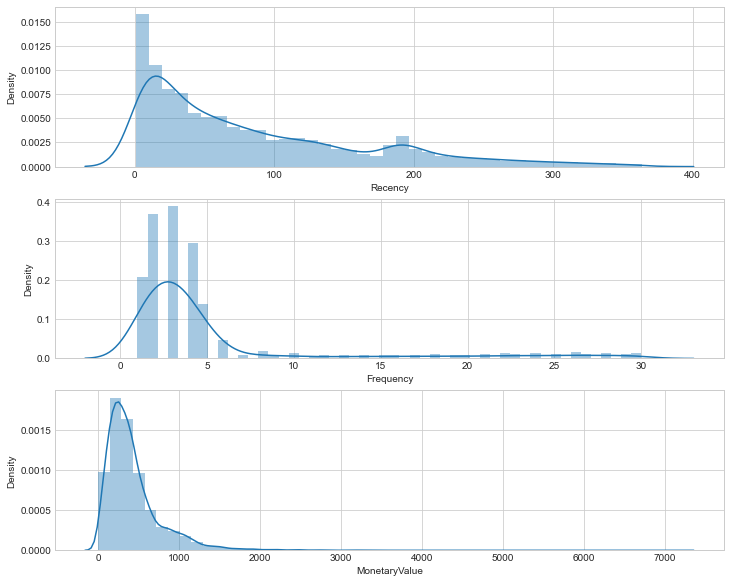

In [5]:
# Plot RFM distributions

plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_data['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_data['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_data['MonetaryValue'])
# Show the plot
plt.show()

## Split RFM into quantiles for scoring and segmentation

In [6]:
# --Calculate R, F and M groups--

# Create labels for Recency, Frequency and MonetaryValue
r_labels = range(4, 0, -1); f_labels = range(1, 5); m_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm_data['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(rfm_data['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(rfm_data['MonetaryValue'], q=4, labels=m_labels)
# Create new columns R and F 
rfm_data = rfm_data.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

rfm_data.head()


,Frequency,MonetaryValue,LastTrxDate,Recency,R,F,M
CardID,,,,,,,
C0100000199,3,597.00,2001-12-29,2,4,2,4
C0100000343,6,700.94,2001-09-07,115,2,4,4
C0100000375,4,223.98,2001-11-01,60,2,3,2
C0100000482,4,197.98,2001-12-10,21,3,3,1
C0100000689,2,428.00,2001-12-26,5,4,1,3


In [7]:
def join_rfm(x):
    return (str(x['R']) + str(x['F']) + str(x['M']))

rfm_data['RFM Segments'] = rfm_data.apply(join_rfm, axis=1)
rfm_data['RFM Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)
rfm_data.describe()


,Frequency,MonetaryValue,Recency,RFM Score
count,12589.000000,12589.000000,12589.000000,12589.000000
mean,5.498054,428.665782,85.375804,7.294384
std,6.649775,355.381602,81.017909,2.459991
min,1.000000,1.490000,1.000000,3.000000
25%,2.000000,206.800000,20.000000,6.000000
50%,3.000000,341.440000,58.000000,7.000000
75%,5.000000,528.000000,129.000000,9.000000
max,30.000000,7192.000000,364.000000,12.000000


## Group customers by their RFM Scores

In [8]:
def rfm_type(df):
    if df['RFM Score'] > 9:
        return '1 Most Valuable'
    elif df['RFM Score'] < 6:
        return '3 Most Likely to churn'
    else:
        return '2 Loyal members'
    
rfm_data['RFM Type'] = rfm_data.apply(rfm_type, axis=1)

rfm_data_agg = rfm_data.groupby(['RFM Type']).agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count']})
rfm_data_agg

Recency  Frequency MonetaryValue      
                              mean       mean          mean count
RFM Type                                                         
1 Most Valuable          22.595563  14.324659    845.117184  2344
2 Loyal members          68.884295   4.165372    397.662053  7208
3 Most Likely to churn  172.971353   1.848535    180.826727  3037